<a href="https://colab.research.google.com/github/ValBrain/models/blob/master/Bertweet_model_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

!pip install transformers
!pip install emoji

from transformers import AutoModel, AutoTokenizer, BertForSequenceClassification, BertTokenizer

In [2]:
# Datasets de entrenamiento.
train = {
    'anger': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/anger-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity']),
    'fear': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/fear-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity']),
    'joy': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/joy-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity']),
    'sadness': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/sadness-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'])
}
# Datasets que deberán predecir para la competencia.
target = {
    'anger': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/anger-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE']),
    'fear': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/fear-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE']),
    'joy': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/joy-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE']),
    'sadness': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/sadness-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE'])}

In [3]:
# Ejemplo de algunas filas aleatorias del dataset etiquetado:
train['anger'].sample(5)

,id,tweet,class,sentiment_intensity
586,10586,my momma irritate me asking all these question...,anger,medium
216,10216,I don't talk about politics because people now...,anger,medium
142,10142,i had an hour of football practice under the b...,anger,high
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,high
161,10161,@Slippus @PureGym yeah I received a fine toda...,anger,medium


# Clase Dataset


In [4]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, padding_side = 'right')

def pad_sequences(datalist, pad_idx):

  lens = [len(sentence) for sentence, label in datalist]
  max_len = max(lens)

  batch = torch.IntTensor([list(data[0]) + [pad_idx]*(max_len - lens[i]) for i, data in enumerate(datalist)])
  labels = torch.LongTensor([label for sentence, label in datalist])

  return batch, labels


class TweetDataSet(Dataset):

  def __init__(self, data):

    self.intensities = list(data['sentiment_intensity'].unique())

    self.intensity2idx = {intensity: i for i, intensity in enumerate(self.intensities)}

    self.X = [tokenizer.encode(line) for line in list(data['tweet'].values)] # tokinized ids
    self.Y = [self.intensity2idx[intensity] for intensity in list(data['sentiment_intensity'].values)]

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return torch.tensor(self.X[i]), torch.tensor(self.Y[i])

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


# Modelo

In [5]:
class BertweetCLF(nn.Module):

  def __init__(self):
    super(BertweetCLF, self).__init__()

    self.bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

    #self.lstm = nn.LSTM(768, 1024, num_layers = 2, dropout = 0.3)

    #self.fc = nn.Linear(768, 3)


  def forward(self, X):

    X = self.bertweet(X)

    #H, S  = self.lstm(torch.transpose(X[0], 0, 1))
    # return self.fc(X[1])
    return X[1]  # X[1] -> (batch_size, 768)

  def num_parameters(self):
    total = 0
    for p in self.parameters():
      total += p.numel()
      
    return total

class linear_layer(nn.Module):
  """
  Capa linear o fully connected clásica
  """
  def __init__(self, in_filter = 768, out_filter = 3):
    super(linear_layer, self).__init__()
    mid_1 = 2048#1024
    #mid_2 = 512
    
    self.fc1  = nn.Sequential(
        nn.Linear(in_filter, mid_1),  # (768, 2048)
        nn.ReLU(),
        nn.BatchNorm1d(mid_1)
        )
    
    self.fc2  = nn.Sequential(
        nn.Linear(mid_1, mid_1), # (2048, 2048)
        nn.ReLU(),
        nn.BatchNorm1d(mid_1))
    
    self.fc3  = nn.Sequential(
        nn.Linear(mid_1, out_filter), # (2048, 3)
        nn.ReLU(),
        nn.BatchNorm1d(out_filter))

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    out = self.fc3(x)
    return out

# Dataset

In [19]:
batch_size, num_workers = 32, 4

### Angry

### Fear

### Joy 

In [6]:
## Angry 
dataset_angry = TweetDataSet(train['anger'])
train_split_angry = int(len(dataset_angry)*0.9)
train_dataset_angry, val_dataset_angry = torch.utils.data.random_split(dataset_angry, [train_split_angry, len(dataset_angry) - train_split_angry])

train_dataloader_angry = DataLoader(
    train_dataset_angry, batch_size=batch_size, shuffle=True, 
    collate_fn=lambda data_list: pad_sequences(data_list, tokenizer.pad_token_id))

val_dataloader_angry = DataLoader(
    val_dataset_angry, batch_size=batch_size, shuffle=False, 
    collate_fn=lambda data_list: pad_sequences(data_list, tokenizer.pad_token_id))

print(len(dataset_angry))
print(len(train_dataset_angry))
print(len(val_dataset_angry))

## Fear
dataset_fear = TweetDataSet(train['fear'])
train_split_fear = int(len(dataset_fear)*0.9)
train_dataset_fear, val_dataset_fear = torch.utils.data.random_split(dataset_fear, [train_split_fear, len(dataset_fear) - train_split_fear])

train_dataloader_fear = DataLoader(
    train_dataset_fear, batch_size=batch_size, shuffle=True, 
    collate_fn=lambda data_list: pad_sequences(data_list, tokenizer.pad_token_id))

val_dataloader_fear = DataLoader(
    val_dataset_fear, batch_size=batch_size, shuffle=False, 
    collate_fn=lambda data_list: pad_sequences(data_list, tokenizer.pad_token_id))

print(len(dataset_fear))
print(len(train_dataset_fear))
print(len(val_dataset_fear))

## Joy 
dataset_joy = TweetDataSet(train['joy'])
train_split_joy = int(len(dataset_joy)*0.9)
train_dataset_joy, val_dataset_joy = torch.utils.data.random_split(dataset, [train_split_joy, len(dataset_joy) - train_split_joy])

train_dataloader_joy = DataLoader(
    train_dataset_joy, batch_size=batch_size, shuffle=True, 
    collate_fn=lambda data_list: pad_sequences(data_list, tokenizer.pad_token_id))

val_dataloader_joy = DataLoader(
    val_dataset_joy, batch_size=batch_size, shuffle=False, 
    collate_fn=lambda data_list: pad_sequences(data_list, tokenizer.pad_token_id))

print(len(dataset_joy))
print(len(train_dataset_joy))
print(len(val_dataset_joy))

## Sadness
dataset_sadness = TweetDataSet(train['sadness'])
train_split_sadness = int(len(dataset_sadness)*0.9)
train_dataset_sadness, val_dataset_sadness = torch.utils.data.random_split(dataset_sadness, [train_split_sadness, len(dataset_sadness) - train_split_sadness])

train_dataloader_sadness = DataLoader(
    train_dataset_sadness, batch_size=batch_size, shuffle=True, 
    collate_fn=lambda data_list: pad_sequences(data_list, tokenizer.pad_token_id))

val_dataloader_sadness = DataLoader(
    val_dataset_sadness, batch_size=batch_size, shuffle=False, 
    collate_fn=lambda data_list: pad_sequences(data_list, tokenizer.pad_token_id))

print(len(dataset_sadness))
print(len(train_dataset_sadness))
print(len(val_dataset_sadness))



941
846
95


# Entrenamiento

In [7]:
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'CC6205_PLN/'
competencia_1_dir = base_dir + 'Competencias/Competencia_1/'
os.makedirs(competencia_1_dir, exist_ok=True)
weights_data_path = competencia_1_dir + 'Experimento_vale/'
os.makedirs(weights_data_path, exist_ok=True)

Mounted at /content/gdrive


In [10]:
def train_net(net, class_layer, epochs, pad_idx, device = 'cuda'):
  net = net.to(device)
  class_layer = class_layer.to(device)
  # Comienza el entrenamiento
  optimizador = optim.AdamW(class_layer.parameters(), lr=1e-5, weight_decay=1e-2)
  loss_fn     = nn.CrossEntropyLoss(ignore_index=pad_idx)
  loss_train, acc_train, loss_dev, acc_dev = [], [], [], []

  best_acc, best_epoch  = 0.0, 0.0
  for epoch in range(1,epochs+1):
    # Variables para las métricas de training
    run_loss, run_acc, items = 0.0, 0.0, 0.0
    net.eval()
    class_layer.train()
    for i, data in enumerate(train_dataloader):
      X, target = data
      X, target = X.to(device), target.to(device)
 
      # Backprop y descenso del gradiente estocastico
      optimizador.zero_grad()
      with torch.no_grad():
        latent_space = net.forward(X)
      logits = class_layer.forward(latent_space)

      L = loss_fn(logits, target)
      L.backward()
      optimizador.step()

      # Ahora calculamos las métricas y reportamos
      items += len(target)
      run_loss += L.item()
      Y_pred = F.softmax(logits, dim=1)
      max_prob, max_idx = torch.max(Y_pred, dim=1)
      run_acc += torch.sum(max_idx == target).item()
      info = f'\rEpoch {epoch}: '
      info += f'Train Loss:{run_loss/(i+1):02.5f}, '
      info += f'Train Acc:{run_acc/items*100:02.1f}%'
      sys.stdout.write(info)

    loss_train.append(run_loss/(i+1)) # se agregan resultados para plotear
    acc_train.append(run_acc/items*100)
    
    # Validacion -------------------------------------------
    val_loss, val_acc, items = 0.0, 0.0, 0.0
    class_layer.eval()
    net.eval()
    with torch.no_grad():
      for i, data in enumerate(val_dataloader):
        X, target = data
        X, target = X.to(device), target.to(device)
        latent_space = net.forward(X)
        logits  = class_layer.forward(latent_space)
        val_loss += loss_fn(logits, target).item()
        # Ahora calculamos las métricas y reportamos
        items += len(target)
        Y_pred = F.softmax(logits, dim=1)
        max_prob, max_idx = torch.max(Y_pred, dim=1)
        val_acc += torch.sum(max_idx == target).item()

    epoch_acc_val = val_acc
    if epoch_acc_val > best_acc:
        best_acc        = epoch_acc_val
        best_epoch      = epoch
        torch.save(class_layer.state_dict(), weights_data_path  + 'linear_model_weights.pth')
        

    info = f', Val Loss:{val_loss/(i+1):02.5f}'
    info += f', Val Acc:{val_acc/items*100:02.2f}%.\n'
    sys.stdout.write(info)

    loss_dev.append(val_loss/(i+1)) # se agregan resultados para plotear
    acc_dev.append(val_acc/items*100)
  print("--------------------------------------------------------")
  print('Best Model found in epoch: {}, with Validation Accuracy: {}'.format(best_epoch, best_acc))  
  return loss_train, acc_train, loss_dev, acc_dev

In [11]:
bertweet_model  = BertweetCLF()
clasificator    = linear_layer()
print("Parametros totales de la red:",bertweet_model.num_parameters())

EPOCHS = 400
loss_train, acc_train, loss_dev, acc_dev = train_net(bertweet_model, clasificator, EPOCHS, tokenizer.pad_token_id)

Parametros totales de la red: 134899968
Epoch 1: Train Loss:1.21222, Train Acc:33.8%, Val Loss:1.07064, Val Acc:13.68%.
Epoch 2: Train Loss:1.00677, Train Acc:36.3%, Val Loss:1.04162, Val Acc:21.05%.
Epoch 3: Train Loss:0.95167, Train Acc:38.4%, Val Loss:1.05625, Val Acc:23.16%.
Epoch 4: Train Loss:0.91228, Train Acc:39.2%, Val Loss:1.10481, Val Acc:31.58%.
Epoch 5: Train Loss:0.88216, Train Acc:41.5%, Val Loss:1.04421, Val Acc:30.53%.
Epoch 6: Train Loss:0.74866, Train Acc:45.4%, Val Loss:0.97487, Val Acc:31.58%.
Epoch 7: Train Loss:0.77221, Train Acc:44.0%, Val Loss:1.07716, Val Acc:40.00%.
Epoch 8: Train Loss:0.75451, Train Acc:45.5%, Val Loss:1.01005, Val Acc:41.05%.
Epoch 9: Train Loss:0.69590, Train Acc:45.9%, Val Loss:0.99546, Val Acc:48.42%.
Epoch 10: Train Loss:0.62551, Train Acc:47.9%, Val Loss:1.00654, Val Acc:35.79%.
Epoch 11: Train Loss:0.60740, Train Acc:51.3%, Val Loss:1.01375, Val Acc:48.42%.
Epoch 12: Train Loss:0.65717, Train Acc:51.5%, Val Loss:0.98890, Val Acc:42.11

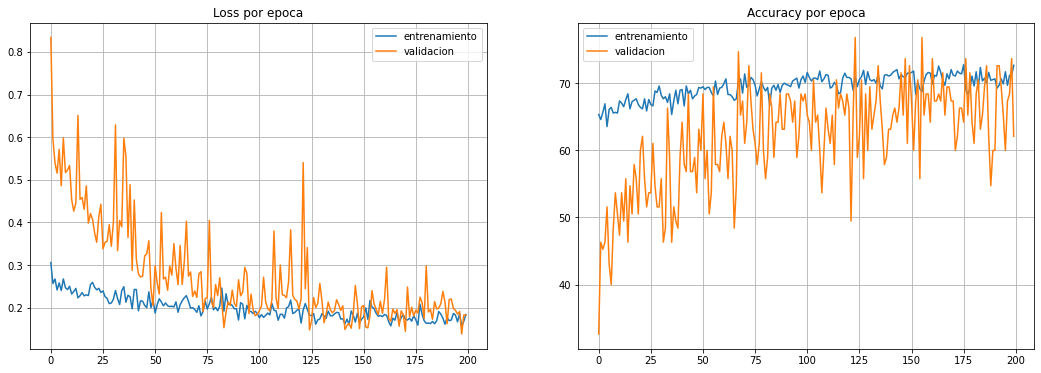

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

axes[0].plot(loss_train, label = 'entrenamiento')
axes[0].plot(loss_dev, label = 'validacion')
axes[0].set_title("Loss por epoca")
axes[0].legend(), axes[0].grid()

axes[1].plot(acc_train, label = 'entrenamiento')
axes[1].plot(acc_dev, label = 'validacion')
axes[1].set_title("Accuracy por epoca")
axes[1].legend(), axes[1].grid()

plt.show()

# Zona de webeo

In [13]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base").cuda()

# INPUT TWEET IS ALREADY NORMALIZED!
#train_sentences = [tokenizer.encode(line) for line in list(train['anger']['tweet'].values)]
#train_labels = list(train['anger']['sentiment_intensity'].values)
#train_dataset = TweetDataSet(train_sentences)

train_dataset = TweetDataSet(train['anger'])

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, 
    collate_fn=lambda data_list: pad_sequences(data_list, tokenizer.pad_token_id))

for data in train_dataloader:
  X, Y = data
  break

print(X.size())

features = bertweet(X.cuda())

print(features.to_tuple()[0].size())
print(features.to_tuple()[1].size())

torch.Size([32, 43])
torch.Size([32, 43, 768])
torch.Size([32, 768])
